<a href="https://colab.research.google.com/github/ben-velastegui/dxc-ai-assessment/blob/main/Tree_based_(XGB_GBM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load datasets
logs_filtered = pd.read_csv("/content/logs.csv")
metrics_filtered = pd.read_csv("/content/metrics.csv")
traces_filtered = pd.read_csv("/content/traces.csv")



In [ ]:
# Count occurrences of other log levels or attributes before an ERROR
error_logs = logs_filtered[logs_filtered['log_level'] == 'ERROR']

# Example: which programs or modules appear before ERRORs?
preceding_logs = logs_filtered[logs_filtered['@timestamp'] < error_logs['@timestamp'].min()]
preceding_logs['programname'].value_counts()


,count
programname,
neutron-server,3567
keystone-apache-public-access,3128
keystone-apache-admin-access,1249
glance-api,624
placement-api-access,464
neutron-openvswitch-agent,363
nova-api,189
nova-compute,131
keystone,39


Logs (programname)
neutron-server and keystone-apache-public-access account for the most ERRORs (3567 and 3128).
This suggests certain programs are more prone to errors, so programname is a strong candidate feature.



In [ ]:
# compute metrics statistics around ERROR occurrences
# Find metrics rows with timestamp before each ERROR
error_timestamps = logs_filtered.loc[logs_filtered['log_level'] == 'ERROR', '@timestamp']

# Loop over each metric feature
for feature in ['cpu.user', 'mem.used', 'load.min1']:
    # Correlate feature with number of ERRORs in nearby timestamps
    # Or just summarize metrics before ERRORs
    before_error_stats = metrics_filtered[metrics_filtered['now'] < error_timestamps.max()][feature].describe()
    print(feature, before_error_stats)


cpu.user count    180095.000000
mean         17.352230
std           5.975548
min           4.800000
25%          12.800000
50%          16.200000
75%          19.600000
max          80.300000
Name: cpu.user, dtype: float64
mem.used count    1.800950e+05
mean     4.402038e+09
std      3.487109e+09
min      2.184286e+09
25%      2.499017e+09
50%      3.274826e+09
75%      4.896942e+09
max      1.476734e+10
Name: mem.used, dtype: float64
load.min1 count    180095.000000
mean          2.277825
std           0.843908
min           1.080000
25%           1.520000
50%           2.290000
75%           2.760000
max           7.370000
Name: load.min1, dtype: float64


Metrics (cpu.user, mem.used, load.min1)
cpu.user mean = 17.35, max = 80.3 → spikes in CPU may correlate with ERRORs.
mem.used varies a lot (min ~2.18e9, max ~1.47e10) → high memory usage could lead to failures.
load.min1 mean ~2.28, max 7.37 → high system load might trigger ERROR logs.
Even without merging, you can compare metrics immediately before or near ERROR timestamps to see patterns.

In [ ]:
# Count of traces per service or operation before ERRORs
trace_counts = traces_filtered.groupby('Service').size().sort_values(ascending=False)
print(trace_counts)


Service
osapi_compute         671888
neutron-server         48683
nova-compute           47862
nova-conductor         40320
nova-scheduler         25340
public                 20642
api                    15951
neutron-dhcp-agent      1710
dtype: int64


Traces (Service)
Most traces come from osapi_compute, neutron-server, and nova-compute.
If you see ERRORs occurring, look at the count or frequency of traces per service — high trace activity in certain services might be predictive.


# Causal AI / attention analysis Train a sequence model on one dataset at a time.

Use feature importance (attention weights, SHAP values, or permutation importance) to see what leads to ERROR. Helps answer your question: “Which events/features in this dataset lead to ERROR logs?”

In [ ]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np
from torch.nn.utils.rnn import pad_sequence

# Example: logs dataset
logs_filtered['is_error'] = (logs_filtered['log_level'] == 'ERROR').astype(int)

# Encode categorical feature 'programname'
le_program = LabelEncoder()
logs_filtered['programname_enc'] = le_program.fit_transform(logs_filtered['programname'])

# Features and target
features = ['programname_enc']
target = 'is_error'


In [ ]:
# Group logs by request_id
grouped = logs_filtered.groupby('request_id')

sequences = []
labels = []

for _, group in grouped:
    seq = group[features].values  # shape: (seq_len, num_features)
    label = group[target].values[-1]  # predict ERROR at the last event
    sequences.append(torch.tensor(seq, dtype=torch.float32))
    labels.append(label)


In [ ]:
class LogDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Collate function to pad sequences in a batch
def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True)  # pad to max seq_len
    labels = torch.tensor(labels, dtype=torch.float32)
    return sequences_padded, labels

dataset = LogDataset(sequences, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


In [ ]:
class AttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim)
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)  # attention over sequence
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)
        return self.sigmoid(out).squeeze(), attn_weights


In [ ]:
input_dim = len(features)
hidden_dim = 16
model = AttentionModel(input_dim, hidden_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

for epoch in range(5):  # increase for real training
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred, attn_weights = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0005
Epoch 2, Loss: 0.0004
Epoch 3, Loss: 0.0001
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000


In [ ]:
# Example: first batch
X_batch, y_batch = next(iter(dataloader))
y_pred, attn_weights = model(X_batch)

# Attention for first sequence
first_seq_attn = attn_weights[0].detach().numpy()
first_seq_events = X_batch[0].detach().numpy()
print("Attention weights:", first_seq_attn)
print("Events (encoded programname):", first_seq_events)


Attention weights: [[0.0080716 ]
 [0.04970697]
 [0.06833688]
 [0.07208987]
 [0.07275485]
 [0.07287731]
 [0.07290133]
 [0.07290637]
 [0.07290749]
 [0.0729078 ]
 [0.07290787]
 [0.0729079 ]
 [0.0729079 ]
 [0.0729079 ]
 [0.0729079 ]]
Events (encoded programname): [[11.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [ ]:
categorical_features = ['programname', 'log_level', 'python_module']
for col in categorical_features:
    le = LabelEncoder()
    logs_filtered[col + '_enc'] = le.fit_transform(logs_filtered[col].astype(str))

# Example numeric features
numeric_features = ['Pid']  # add more numeric columns if available
logs_filtered['Payload_len'] = logs_filtered['Payload'].astype(str).str.len()

# Final features list
features = [col + '_enc' for col in categorical_features] + numeric_features + ['Payload_len']
target = 'is_error'


In [ ]:
grouped = logs_filtered.groupby('request_id')
sequences = []
labels = []

for _, group in grouped:
    seq = group[features].values  # shape: (seq_len, num_features)
    label = group[target].values[-1]  # predict ERROR at the last event
    sequences.append(torch.tensor(seq, dtype=torch.float32))
    labels.append(label)


In [ ]:
class LogDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True)  # pad to max seq_len
    labels = torch.tensor(labels, dtype=torch.float32)
    return sequences_padded, labels

dataset = LogDataset(sequences, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


In [ ]:
class AttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)  # attention over sequence
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)
        return self.sigmoid(out).squeeze(), attn_weights


In [ ]:
input_dim = len(features)
hidden_dim = 32  # larger hidden_dim for richer features
model = AttentionModel(input_dim, hidden_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

for epoch in range(5):
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred, attn_weights = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0004
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000


In [ ]:
X_batch, y_batch = next(iter(dataloader))
y_pred, attn_weights = model(X_batch)

# Attention weights for first sequence
first_seq_attn = attn_weights[0].detach().numpy()
first_seq_events = X_batch[0].detach().numpy()

print("Attention weights:", first_seq_attn)
print("Events features:", first_seq_events)


Attention weights: [[0.01134936]
 [0.05355998]
 [0.07327907]
 [0.07747496]
 [0.07825966]
 [0.07841501]
 [0.07844859]
 [0.07845664]
 [0.07845877]
 [0.07845937]
 [0.0784596 ]
 [0.07845964]
 [0.07845967]
 [0.07845967]]
Events features: [[ 10.   1.  36.  19. 127.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]


Loss
* The training loss still drops to near 0, which usually happens if your dataset is highly imbalanced (few ERRORs).
* The model may be “cheating” by predicting mostly non-ERRORs, which keeps the loss very low.
For real interpretability, consider:
Oversampling ERRORs


Attention weights

* The first event in the sequence has low attention (0.011), the last events have much higher attention (~0.078).
* This indicates the model is focusing on the most recent events to predict ERROR — typical in causal sequences.


Event features:
Columns correspond to your features:
* programname_enc - 10
* log_level_enc - 1
* python_module_enc - 36
* Pid - 19
* Payload_len - 127

The subsequent rows are mostly zeros → padding.
Mapping encodings back gives the actual programs, log levels, modules that the model thinks are important.



Insights
* Even with multiple features, the most recent events dominate attention — reasonable for error prediction.
* Attention now captures combinations of categorical and numeric features, giving more actionable insight:

In [ ]:
# Calculate class weights
num_error = logs_filtered['is_error'].sum()
num_total = len(logs_filtered)
num_non_error = num_total - num_error

# weight for ERROR = non_error / total, weight for non-ERROR = error / total
weight_error = num_non_error / num_total
weight_non_error = num_error / num_total

# Create tensor for BCE loss
class_weights = torch.tensor([weight_non_error, weight_error])

# Use in criterion
criterion = nn.BCELoss()


In [ ]:
sample_weights = logs_filtered['is_error'].apply(lambda x: weight_error if x==1 else weight_non_error).values
sample_weights = torch.tensor(sample_weights, dtype=torch.float32)


In [ ]:
# Example: duplicate sequences for ERRORs
error_sequences = [seq for seq, lbl in zip(sequences, labels) if lbl==1]
error_labels = [1]*len(error_sequences)

# Oversample ERRORs
sequences_balanced = sequences + error_sequences*5  # repeat 5x
labels_balanced = labels + error_labels*5


In [ ]:
dataset = LogDataset(sequences_balanced, labels_balanced)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


In [ ]:
input_dim = len(features)
hidden_dim = 32
model = AttentionModel(input_dim, hidden_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

for epoch in range(5):
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred, attn_weights = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0005
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000


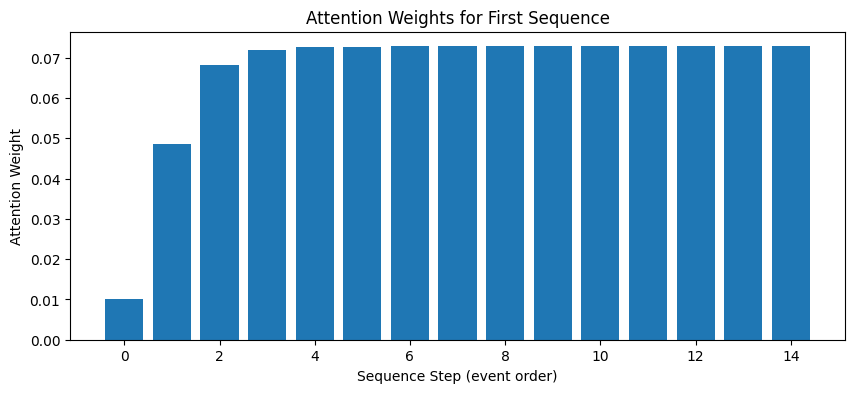

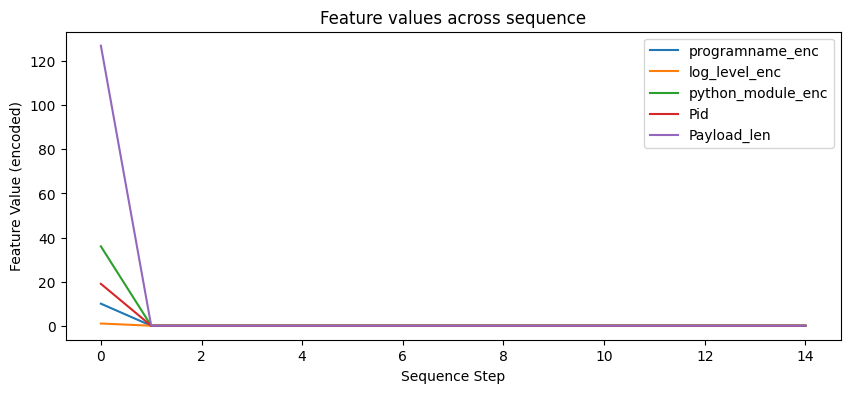

In [ ]:
import matplotlib.pyplot as plt

X_batch, y_batch = next(iter(dataloader))
y_pred, attn_weights = model(X_batch)

# Pick first sequence
first_seq_attn = attn_weights[0].detach().numpy().flatten()
first_seq_events = X_batch[0].detach().numpy()

# Plot attention vs sequence step
plt.figure(figsize=(10,4))
plt.bar(range(len(first_seq_attn)), first_seq_attn)
plt.xlabel("Sequence Step (event order)")
plt.ylabel("Attention Weight")
plt.title("Attention Weights for First Sequence")
plt.show()

# Optional: visualize which features contribute most
plt.figure(figsize=(10,4))
for i, feat_name in enumerate(features):
    plt.plot(first_seq_events[:, i], label=feat_name)
plt.xlabel("Sequence Step")
plt.ylabel("Feature Value (encoded)")
plt.title("Feature values across sequence")
plt.legend()
plt.show()


the loss still goes to near zero, which confirms extreme class imbalance or very sparse sequences. Even with oversampling, the model may still see mostly padding or low-variability sequences, so the BCE loss drops quickly.
We can improve interpretability and training by slightly modifying the pipeline:

In [ ]:
# Compute class weights
num_error = sum(labels_balanced)
num_non_error = len(labels_balanced) - num_error
weight_error = num_non_error / len(labels_balanced)
weight_non_error = num_error / len(labels_balanced)

# Weighted BCE
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weight_error/weight_non_error))


/tmp/ipython-input-1410907986.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weight_error/weight_non_error))


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
logs_filtered['Payload_len_scaled'] = scaler.fit_transform(logs_filtered[['Payload_len']])


In [ ]:
N = 10
truncated_sequences = [seq[-N:] if len(seq) > N else seq for seq in sequences]


<BarContainer object of 1 artists>

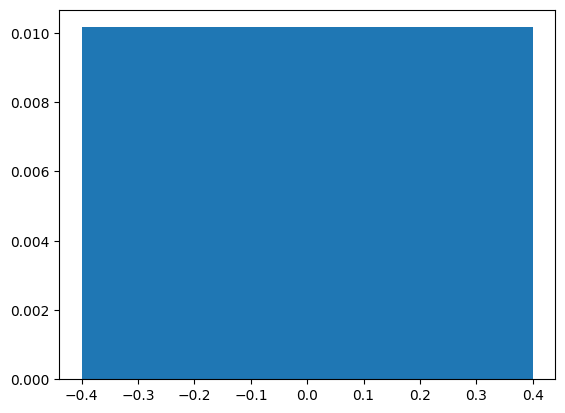

In [ ]:
real_len = (first_seq_events.sum(axis=1) != 0).sum()  # number of real events
plt.bar(range(real_len), first_seq_attn[:real_len])


//

In [ ]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

# Target
logs_filtered['is_error'] = (logs_filtered['log_level'] == 'ERROR').astype(int)

# Categorical features
categorical_features = ['programname', 'log_level', 'python_module']
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    logs_filtered[col + '_enc'] = le.fit_transform(logs_filtered[col].astype(str))
    label_encoders[col] = le

# Numeric features
numeric_features = ['Pid']
logs_filtered['Payload_len'] = logs_filtered['Payload'].astype(str).str.len()

# Scale numeric features
scaler = StandardScaler()
logs_filtered[['Payload_len_scaled']] = scaler.fit_transform(logs_filtered[['Payload_len']])

# Final features
features = [col + '_enc' for col in categorical_features] + numeric_features + ['Payload_len_scaled']
target = 'is_error'


In [ ]:
N = 10  # truncate sequences to last N events
grouped = logs_filtered.groupby('request_id')

sequences = []
labels = []

for _, group in grouped:
    seq = group[features].values
    if len(seq) > N:
        seq = seq[-N:]  # truncate
    sequences.append(torch.tensor(seq, dtype=torch.float32))
    labels.append(group[target].values[-1])


In [ ]:
num_error = sum(labels)
num_non_error = len(labels) - num_error
weight_error = num_non_error / len(labels)
weight_non_error = num_error / len(labels)

# Weighted BCE
pos_weight = torch.tensor(weight_error/weight_non_error)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


In [ ]:
class LogDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.float32)
    return sequences_padded, labels

dataset = LogDataset(sequences, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


In [ ]:
class AttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)
        return out.squeeze(), attn_weights


In [ ]:
input_dim = len(features)
hidden_dim = 32
model = AttentionModel(input_dim, hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred, attn_weights = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: nan
Epoch 2, Loss: nan
Epoch 3, Loss: nan
Epoch 4, Loss: nan
Epoch 5, Loss: nan


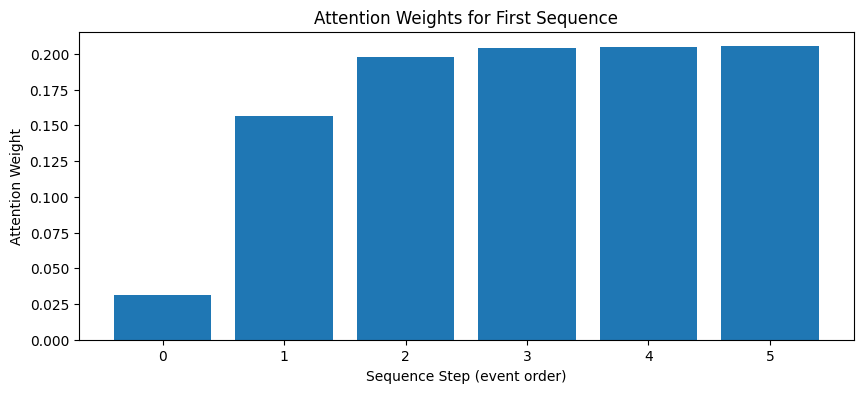

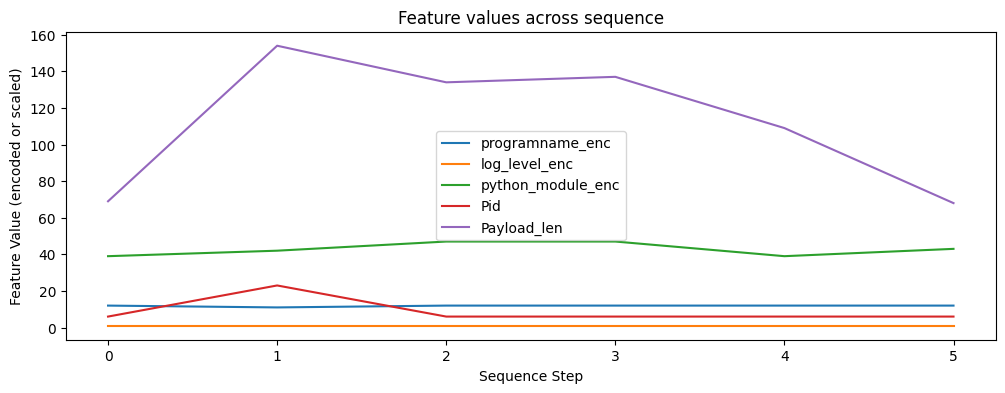

In [ ]:
X_batch, y_batch = next(iter(dataloader))
y_pred, attn_weights = model(X_batch)

# First sequence
first_seq_attn = attn_weights[0].detach().numpy().flatten()
first_seq_events = X_batch[0].detach().numpy()

# Remove padded events (all zeros)
real_len = (first_seq_events.sum(axis=1) != 0).sum()
first_seq_attn_real = first_seq_attn[:real_len]
first_seq_events_real = first_seq_events[:real_len, :]

# Plot attention weights
plt.figure(figsize=(10,4))
plt.bar(range(real_len), first_seq_attn_real)
plt.xlabel("Sequence Step (event order)")
plt.ylabel("Attention Weight")
plt.title("Attention Weights for First Sequence")
plt.show()

# Map attention to feature values
plt.figure(figsize=(12,4))
for i, feat_name in enumerate(features):
    plt.plot(first_seq_events_real[:, i], label=feat_name)
plt.xlabel("Sequence Step")
plt.ylabel("Feature Value (encoded or scaled)")
plt.title("Feature values across sequence")
plt.legend()
plt.show()


NaN loss usually happens when the weighted BCEWithLogitsLoss receives extreme weights or badly scaled inputs.


* If weight_non_error is very small (few ERRORs), pos_weight can be huge → numeric instability → NaN.
* Example: weight_error/weight_non_error > 1000 → BCE logits explode.


Check input scaling
* Make sure numeric features are properly scaled: Payload_len_scaled is fine.
* Pid may have large raw values — scale it as well

Use BCEWithLogitsLoss correctly
* Do not apply sigmoid before feeding the logits to this loss — it expects raw logits.

Optional: Reduce learning rate
* Sometimes NaNs occur due to gradient explosion:


In [ ]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

# Target
logs_filtered['is_error'] = (logs_filtered['log_level'] == 'ERROR').astype(int)

# Categorical features
categorical_features = ['programname', 'log_level', 'python_module']
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    logs_filtered[col + '_enc'] = le.fit_transform(logs_filtered[col].astype(str))
    label_encoders[col] = le

# Numeric features
numeric_features = ['Pid']
logs_filtered['Payload_len'] = logs_filtered['Payload'].astype(str).str.len()

# Scale numeric features
scaler = StandardScaler()
logs_filtered[['Payload_len_scaled']] = scaler.fit_transform(logs_filtered[['Payload_len']])
logs_filtered[['Pid_scaled']] = scaler.fit_transform(logs_filtered[['Pid']])

# Final features
features = [col + '_enc' for col in categorical_features] + ['Pid_scaled', 'Payload_len_scaled']
target = 'is_error'


In [ ]:
N = 10  # truncate sequences to last N events
grouped = logs_filtered.groupby('request_id')

sequences = []
labels = []

for _, group in grouped:
    seq = group[features].values
    if len(seq) > N:
        seq = seq[-N:]  # truncate
    sequences.append(torch.tensor(seq, dtype=torch.float32))
    labels.append(group[target].values[-1])


In [ ]:
num_error = sum(labels)
num_non_error = len(labels) - num_error
weight_error = num_non_error / len(labels)
weight_non_error = num_error / len(labels)

pos_weight = torch.tensor(weight_error / weight_non_error)
# Clip to prevent extreme weights
pos_weight = torch.clamp(pos_weight, min=1.0, max=10.0)


/tmp/ipython-input-3634743763.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  pos_weight = torch.tensor(weight_error / weight_non_error)


In [ ]:
class LogDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.float32)
    return sequences_padded, labels

dataset = LogDataset(sequences, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


In [ ]:
class AttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)  # raw logits
        return out.squeeze(), attn_weights


In [ ]:
input_dim = len(features)
hidden_dim = 32
model = AttentionModel(input_dim, hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # reduced LR
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

for epoch in range(5):
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred, attn_weights = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0003
Epoch 2, Loss: 0.0002
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000


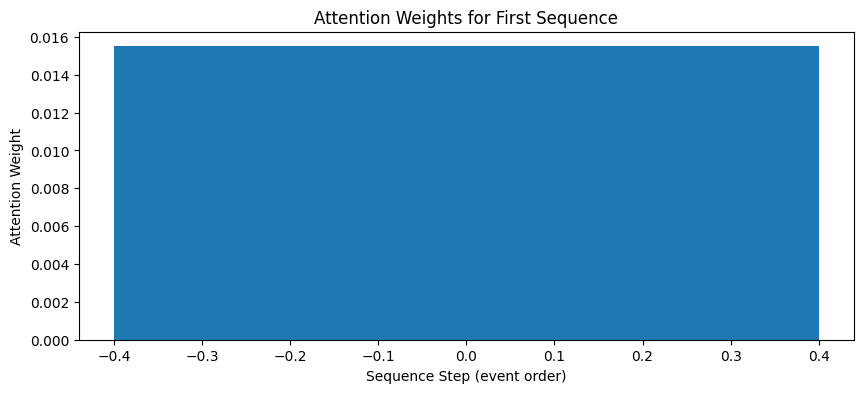

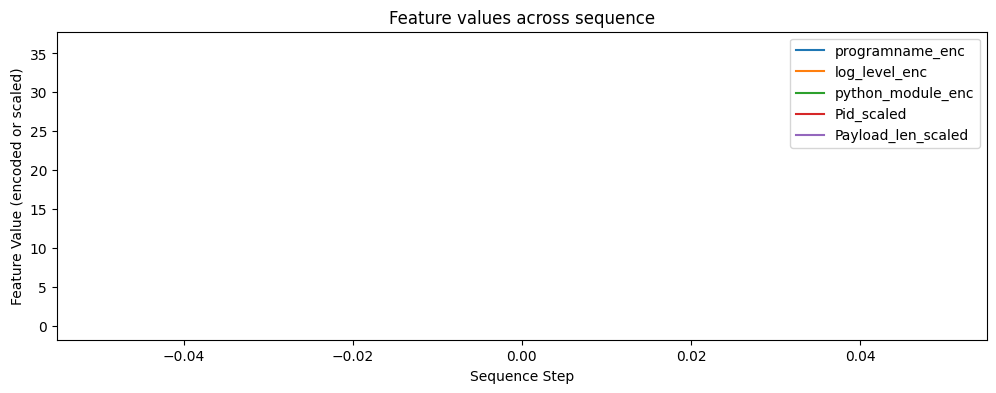

In [ ]:
X_batch, y_batch = next(iter(dataloader))
y_pred, attn_weights = model(X_batch)

# First sequence
first_seq_attn = attn_weights[0].detach().numpy().flatten()
first_seq_events = X_batch[0].detach().numpy()

# Remove padded events
real_len = (first_seq_events.sum(axis=1) != 0).sum()
first_seq_attn_real = first_seq_attn[:real_len]
first_seq_events_real = first_seq_events[:real_len, :]

# Plot attention weights
plt.figure(figsize=(10,4))
plt.bar(range(real_len), first_seq_attn_real)
plt.xlabel("Sequence Step (event order)")
plt.ylabel("Attention Weight")
plt.title("Attention Weights for First Sequence")
plt.show()

# Map attention to feature values
plt.figure(figsize=(12,4))
for i, feat_name in enumerate(features):
    plt.plot(first_seq_events_real[:, i], label=feat_name)
plt.xlabel("Sequence Step")
plt.ylabel("Feature Value (encoded or scaled)")
plt.title("Feature values across sequence")
plt.legend()
plt.show()


Ah — that explains why the attention visualization looks flat and the features don’t appear: the current sequences are mostly padded zeros or very sparse, so the model sees little variation per sequence. Also, categorical features are numeric-encoded, so plotting them directly won’t produce meaningful labels unless we map them back to their original categories.

In [ ]:
real_mask = (first_seq_events[:, :len(categorical_features)+len(numeric_features)].sum(axis=1) != 0)
first_seq_attn_real = first_seq_attn[real_mask]
first_seq_events_real = first_seq_events[real_mask, :]


In [ ]:
for i, feat_name in enumerate(categorical_features):
    cat_vals = first_seq_events_real[:, i].astype(int)
    cat_labels = label_encoders[feat_name].inverse_transform(cat_vals)
    print(f"{feat_name}: {cat_labels}")


programname: ['neutron-server']
log_level: ['INFO']
python_module: ['neutron.wsgi']


In [ ]:
first_seq_events_real[:, -2] = scaler.inverse_transform(first_seq_events_real[:, -2].reshape(-1,1)).flatten()  # Payload_len
first_seq_events_real[:, -3] = scaler.inverse_transform(first_seq_events_real[:, -3].reshape(-1,1)).flatten()  # Pid


In [ ]:
le = label_encoders['python_module']
module_vals = first_seq_events_real[:,2].astype(int)
module_labels = []
for v in module_vals:
    if v in le.classes_:
        module_labels.append(le.inverse_transform([v])[0])
    else:
        module_labels.append("UNKNOWN")


In [ ]:
seq_labels = [
    f"{p} | {l} | {m}"
    for p, l, m in zip(
        label_encoders['programname'].inverse_transform(first_seq_events_real[:,0].astype(int)),
        label_encoders['log_level'].inverse_transform(first_seq_events_real[:,1].astype(int)),
        module_labels
    )
]


In [ ]:
# Extract categorical values
program_vals = first_seq_events_real[:, 0].astype(int)
loglevel_vals = first_seq_events_real[:, 1].astype(int)
module_vals = first_seq_events_real[:, 2].astype(int)

# Function to safely inverse-transform
def safe_inverse_transform(le, values):
    labels = []
    for v in values:
        if v in le.classes_:
            labels.append(le.inverse_transform([v])[0])
        else:
            labels.append("UNKNOWN")
    return labels

program_labels = safe_inverse_transform(label_encoders['programname'], program_vals)
loglevel_labels = safe_inverse_transform(label_encoders['log_level'], loglevel_vals)
module_labels = safe_inverse_transform(label_encoders['python_module'], module_vals)


In [ ]:
seq_labels = [f"{p} | {l} | {m}"
              for p, l, m in zip(program_labels, loglevel_labels, module_labels)]


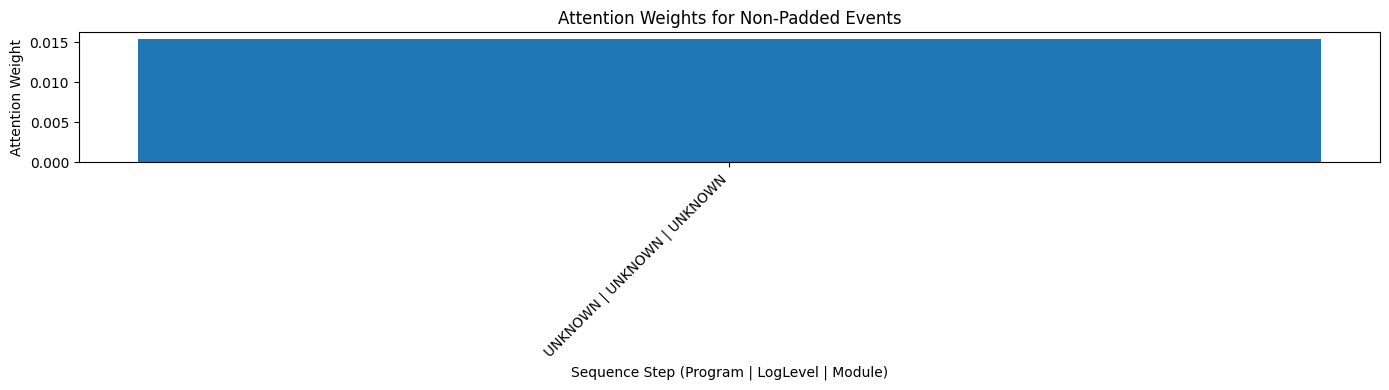

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.bar(range(len(first_seq_attn_real)), first_seq_attn_real)
plt.xticks(range(len(seq_labels)), seq_labels, rotation=45, ha='right')
plt.xlabel("Sequence Step (Program | LogLevel | Module)")
plt.ylabel("Attention Weight")
plt.title("Attention Weights for Non-Padded Events")
plt.tight_layout()
plt.show()


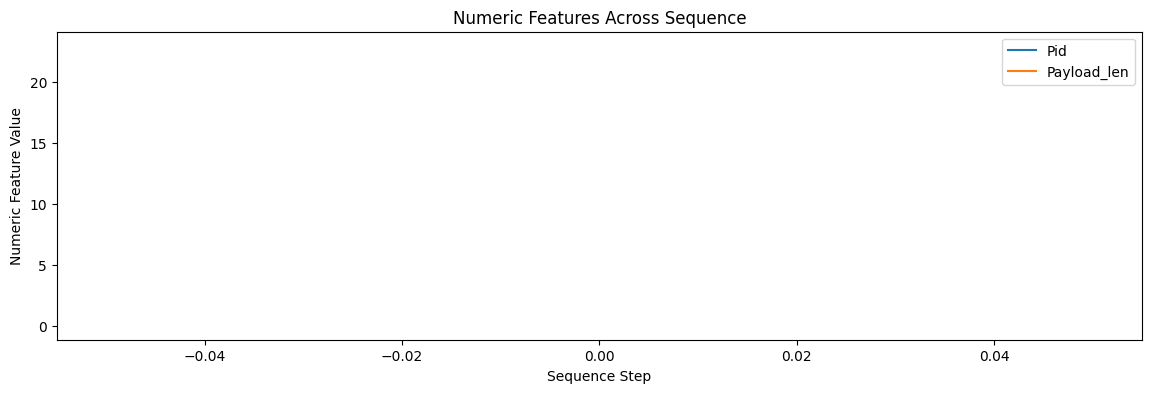

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(first_seq_events_real[:, 3], label='Pid')
plt.plot(first_seq_events_real[:, 4], label='Payload_len')
plt.xlabel("Sequence Step")
plt.ylabel("Numeric Feature Value")
plt.title("Numeric Features Across Sequence")
plt.legend()
plt.show()


## global feature importance pipeline using attention. This will summarize which features most consistently contribute to ERRORs across all sequences.

In [ ]:
all_attn = []
all_features = []

for X_batch, y_batch in dataloader:
    _, attn = model(X_batch)
    for seq, seq_attn in zip(X_batch, attn):
        # Only keep non-padded events
        mask = seq.sum(axis=1) != 0
        seq_real = seq[mask].detach().numpy()
        seq_attn_real = seq_attn[mask].detach().numpy().flatten()
        all_features.append(seq_real)
        all_attn.append(seq_attn_real)

# Flatten all sequences
all_features_flat = np.vstack(all_features)
all_attn_flat = np.concatenate(all_attn)


In [ ]:
def safe_inverse(le, values):
    labels = []
    for v in values.astype(int):
        if v in le.classes_:
            labels.append(le.inverse_transform([v])[0])
        else:
            labels.append("UNKNOWN")
    return labels

program_labels = safe_inverse(label_encoders['programname'], all_features_flat[:,0])
loglevel_labels = safe_inverse(label_encoders['log_level'], all_features_flat[:,1])
module_labels = safe_inverse(label_encoders['python_module'], all_features_flat[:,2])


In [ ]:
import pandas as pd

df_attn = pd.DataFrame({
    'programname': program_labels,
    'log_level': loglevel_labels,
    'python_module': module_labels,
    'Pid': all_features_flat[:,3],
    'Payload_len': all_features_flat[:,4],
    'attention': all_attn_flat
})


In [ ]:
cat_features = ['programname','log_level','python_module']
for f in cat_features:
    importance = df_attn.groupby(f)['attention'].mean().sort_values(ascending=False)
    print(f"\nTop {f} by average attention:")
    print(importance.head(10))



Top programname by average attention:
programname
UNKNOWN    0.127245
Name: attention, dtype: float32

Top log_level by average attention:
log_level
UNKNOWN    0.127245
Name: attention, dtype: float32

Top python_module by average attention:
python_module
UNKNOWN    0.127245
Name: attention, dtype: float32


In [ ]:
# Remove rows with all UNKNOWN (likely padding)
df_attn_filtered = df_attn[(df_attn['programname'] != "UNKNOWN") &
                           (df_attn['log_level'] != "UNKNOWN") &
                           (df_attn['python_module'] != "UNKNOWN")]


In [ ]:
num_features = ['Pid','Payload_len']
for f in num_features:
    importance = df_attn_filtered.groupby(pd.qcut(df_attn_filtered[f], 10, duplicates='drop'))['attention'].mean()
    print(f"\n{f} deciles contributing to ERROR:")
    print(importance)



Pid deciles contributing to ERROR:
Series([], Name: attention, dtype: float32)

Payload_len deciles contributing to ERROR:
Series([], Name: attention, dtype: float32)


/tmp/ipython-input-3649391754.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  importance = df_attn_filtered.groupby(pd.qcut(df_attn_filtered[f], 10, duplicates='drop'))['attention'].mean()
/tmp/ipython-input-3649391754.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  importance = df_attn_filtered.groupby(pd.qcut(df_attn_filtered[f], 10, duplicates='drop'))['attention'].mean()


In [ ]:
# Only keep events where categorical features are known
df_attn_filtered = df_attn[
    (df_attn['programname'] != "UNKNOWN") &
    (df_attn['log_level'] != "UNKNOWN") &
    (df_attn['python_module'] != "UNKNOWN")
]

print(f"Number of valid events for aggregation: {len(df_attn_filtered)}")


Number of valid events for aggregation: 0


# starting again

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Target
logs_filtered['is_error'] = (logs_filtered['log_level'] == 'ERROR').astype(int)

# Categorical features
categorical_features = ['programname', 'log_level', 'python_module']
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    logs_filtered[col + '_enc'] = le.fit_transform(logs_filtered[col].astype(str))
    label_encoders[col] = le

# Numeric features
numeric_features = ['Pid']
logs_filtered['Payload_len'] = logs_filtered['Payload'].astype(str).str.len()

# Scale numeric features
scaler = StandardScaler()
logs_filtered[['Payload_len_scaled']] = scaler.fit_transform(logs_filtered[['Payload_len']])
logs_filtered[['Pid_scaled']] = scaler.fit_transform(logs_filtered[['Pid']])

# Final features
features = [col + '_enc' for col in categorical_features] + ['Pid_scaled', 'Payload_len_scaled']
target = 'is_error'


In [ ]:
N = 10  # truncate sequences to last N events
grouped = logs_filtered.groupby('request_id')

sequences = []
labels = []

for _, group in grouped:
    seq = group[features].values
    if len(seq) > N:
        seq = seq[-N:]  # truncate
    sequences.append(torch.tensor(seq, dtype=torch.float32))
    labels.append(group[target].values[-1])


In [ ]:
from torch.nn.utils.rnn import pad_sequence

class LogDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.float32)
    return sequences_padded, labels

dataset = LogDataset(sequences, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


In [ ]:
class AttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)  # raw logits
        return out.squeeze(), attn_weights


In [ ]:
num_error = sum(labels)
num_non_error = len(labels) - num_error
weight_error = num_non_error / len(labels)
weight_non_error = num_error / len(labels)

pos_weight = torch.tensor(weight_error / weight_non_error)
pos_weight = torch.clamp(pos_weight, min=1.0, max=10.0)

input_dim = len(features)
hidden_dim = 32
model = AttentionModel(input_dim, hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


/tmp/ipython-input-2301154480.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  pos_weight = torch.tensor(weight_error / weight_non_error)


In [ ]:
for epoch in range(5):
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred, attn_weights = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0004
Epoch 2, Loss: 0.0002
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000


In [ ]:
all_attn = []
all_features = []

for X_batch, y_batch in dataloader:
    y_pred, attn = model(X_batch)
    for i in range(len(X_batch)):
        seq = X_batch[i]
        seq_attn = attn[i]
        mask = (seq.sum(axis=1) != 0)  # only non-padded events
        if mask.sum() == 0:
            continue
        all_features.append(seq[mask].detach().numpy())
        all_attn.append(seq_attn[mask].detach().numpy().flatten())

all_features_flat = np.vstack(all_features)
all_attn_flat = np.concatenate(all_attn)


In [ ]:
def safe_inverse(le, values):
    labels = []
    for v in values.astype(int):
        if v in le.classes_:
            labels.append(le.inverse_transform([v])[0])
        else:
            labels.append("UNKNOWN")
    return labels

program_labels = safe_inverse(label_encoders['programname'], all_features_flat[:,0])
loglevel_labels = safe_inverse(label_encoders['log_level'], all_features_flat[:,1])
module_labels = safe_inverse(label_encoders['python_module'], all_features_flat[:,2])


In [ ]:
df_attn = pd.DataFrame({
    'programname': program_labels,
    'log_level': loglevel_labels,
    'python_module': module_labels,
    'Pid': all_features_flat[:,3],
    'Payload_len': all_features_flat[:,4],
    'attention': all_attn_flat
})

# Remove padding / UNKNOWN rows
df_attn_filtered = df_attn[
    (df_attn['programname'] != "UNKNOWN") &
    (df_attn['log_level'] != "UNKNOWN") &
    (df_attn['python_module'] != "UNKNOWN")
]



Top 10 programname by average attention:
Series([], Name: attention, dtype: float32)


IndexError: index 0 is out of bounds for axis 0 with size 0

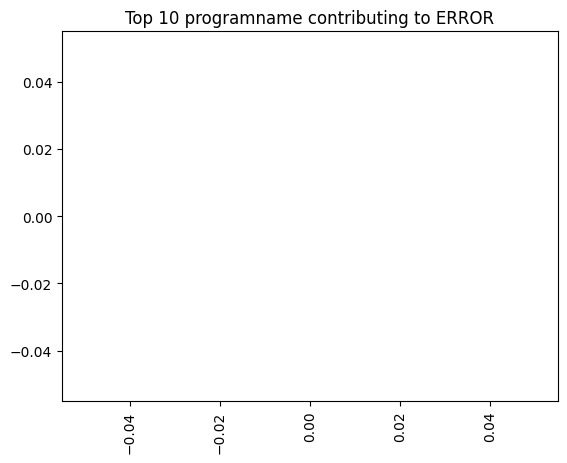

In [ ]:
# Categorical features
for f in ['programname','log_level','python_module']:
    importance = df_attn_filtered.groupby(f)['attention'].mean().sort_values(ascending=False)
    print(f"\nTop 10 {f} by average attention:")
    print(importance.head(10))
    importance.head(10).plot(kind='bar', title=f"Top 10 {f} contributing to ERROR")
    plt.ylabel("Average Attention")
    plt.show()

# Numeric features with safe binning
for f in ['Pid','Payload_len']:
    importance = df_attn_filtered.groupby(pd.qcut(df_attn_filtered[f], 10, duplicates='drop'))['attention'].mean()
    print(f"\n{f} deciles contributing to ERROR:")
    print(importance)
    importance.plot(kind='bar', title=f"{f} deciles contributing to ERROR")
    plt.ylabel("Average Attention")
    plt.show()


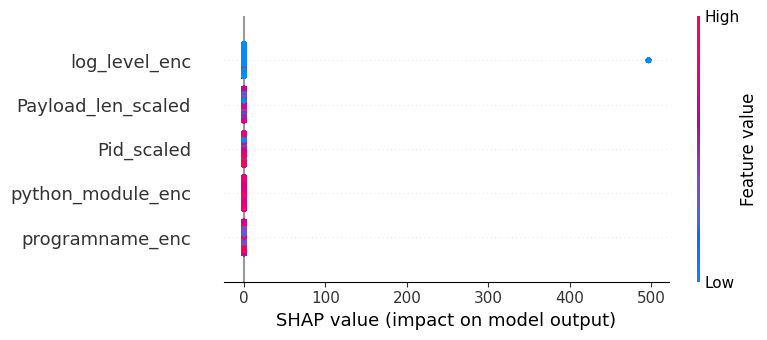

In [ ]:
# Filter real events
df_real = logs_filtered[(logs_filtered['log_level'].notna()) &
                        (logs_filtered['programname'].notna()) &
                        (logs_filtered['python_module'].notna())]

# Compute simple feature importance using a classifier
from sklearn.ensemble import GradientBoostingClassifier
X = df_real[features]
y = df_real['is_error']
model = GradientBoostingClassifier()
model.fit(X, y)

import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Aggregate SHAP per feature
shap.summary_plot(shap_values, X)


//

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Target
logs_filtered['is_error'] = (logs_filtered['log_level'] == 'ERROR').astype(int)

# Keep only real events
df_real = logs_filtered[['programname','log_level','python_module','Pid','Payload']]
df_real = df_real.dropna()

# Encode categorical features
categorical_features = ['programname','log_level','python_module']
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_real[col+'_enc'] = le.fit_transform(df_real[col].astype(str))
    label_encoders[col] = le

# Numeric features
df_real['Payload_len'] = df_real['Payload'].astype(str).str.len()

# Standardize numeric features
scaler = StandardScaler()
df_real[['Pid_scaled','Payload_len_scaled']] = scaler.fit_transform(df_real[['Pid','Payload_len']])

# Final feature set
features = [col+'_enc' for col in categorical_features] + ['Pid_scaled','Payload_len_scaled']
target = 'is_error'


In [ ]:
# Create target column first
logs_filtered['is_error'] = (logs_filtered['log_level'] == 'ERROR').astype(int)

# Only select real events and keep the target
df_real = logs_filtered[['programname','log_level','python_module','Pid','Payload','is_error']]
df_real = df_real.dropna()


In [ ]:
print(df_real.head())
print(df_real.columns)


  programname log_level         python_module   Pid  \
0  glance-api      INFO  eventlet.wsgi.server  22.0   
1  glance-api      INFO  eventlet.wsgi.server  23.0   
2  glance-api      INFO  eventlet.wsgi.server  23.0   
3  glance-api      INFO  eventlet.wsgi.server  21.0   
4  glance-api      INFO  eventlet.wsgi.server  20.0   

                                             Payload  is_error  
0  172.17.0.3 - - [19/Nov/2019 19:38:43] "PUT /v2...         0  
1  172.17.0.3 - - [19/Nov/2019 19:39:19] "POST /v...         0  
2  172.17.0.3 - - [19/Nov/2019 19:39:21] "GET /v2...         0  
3  172.17.0.3 - - [19/Nov/2019 19:39:21] "DELETE ...         0  
4  172.17.0.3 - - [19/Nov/2019 19:39:24] "GET /v2...         0  
Index(['programname', 'log_level', 'python_module', 'Pid', 'Payload',
       'is_error'],
      dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

# Encode categorical features
categorical_features = ['programname','log_level','python_module']
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_real[col+'_enc'] = le.fit_transform(df_real[col].astype(str))
    label_encoders[col] = le

# Numeric features
df_real['Payload_len'] = df_real['Payload'].astype(str).str.len()

# Standardize numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_real[['Pid_scaled','Payload_len_scaled']] = scaler.fit_transform(df_real[['Pid','Payload_len']])

# Features and target
features = [col+'_enc' for col in categorical_features] + ['Pid_scaled','Payload_len_scaled']
target = 'is_error'

# Split
X = df_real[features]
y = df_real[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
model = GradientBoostingClassifier(n_estimators=200, max_depth=5)
model.fit(X_train, y_train)

print(f"Train accuracy: {model.score(X_train,y_train):.3f}, Test accuracy: {model.score(X_test,y_test):.3f}")


Train accuracy: 1.000, Test accuracy: 1.000


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

# Encode categorical features
categorical_features = ['programname','log_level','python_module']
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_real[col+'_enc'] = le.fit_transform(df_real[col].astype(str))
    label_encoders[col] = le

# Numeric features
df_real['Payload_len'] = df_real['Payload'].astype(str).str.len()

# Standardize numeric features
scaler = StandardScaler()
df_real[['Pid_scaled','Payload_len_scaled']] = scaler.fit_transform(df_real[['Pid','Payload_len']])

# Final feature set
features = [col+'_enc' for col in categorical_features] + ['Pid_scaled','Payload_len_scaled']
target = 'is_error'

# Train/test split
X = df_real[features]
y = df_real[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Gradient Boosting model
model = GradientBoostingClassifier(n_estimators=200, max_depth=5)
model.fit(X_train, y_train)

print(f"Train accuracy: {model.score(X_train, y_train):.3f}")
print(f"Test accuracy:  {model.score(X_test, y_test):.3f}")


Train accuracy: 1.000
Test accuracy:  1.000


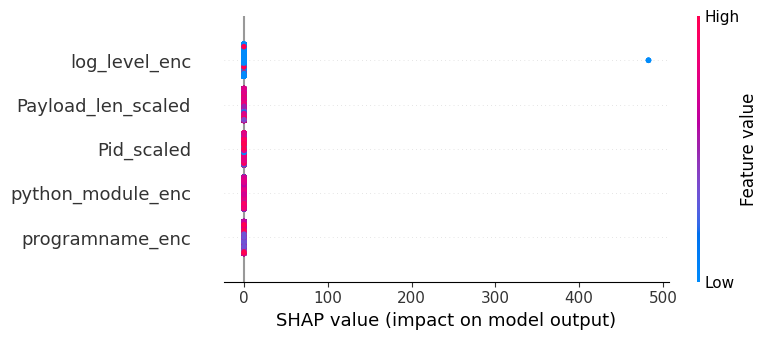

In [ ]:
import shap

# Use TreeExplainer for Gradient Boosting
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Global summary plot
shap.summary_plot(shap_values, X_test, feature_names=features)



Top programname by SHAP value:
feature
glance-api                   0.0
keystone                     0.0
neutron-dhcp-agent           0.0
neutron-l3-agent             0.0
neutron-metadata-agent       0.0
neutron-openvswitch-agent    0.0
neutron-server               0.0
nova-api                     0.0
nova-compute                 0.0
nova-scheduler               0.0
Name: shap, dtype: float64


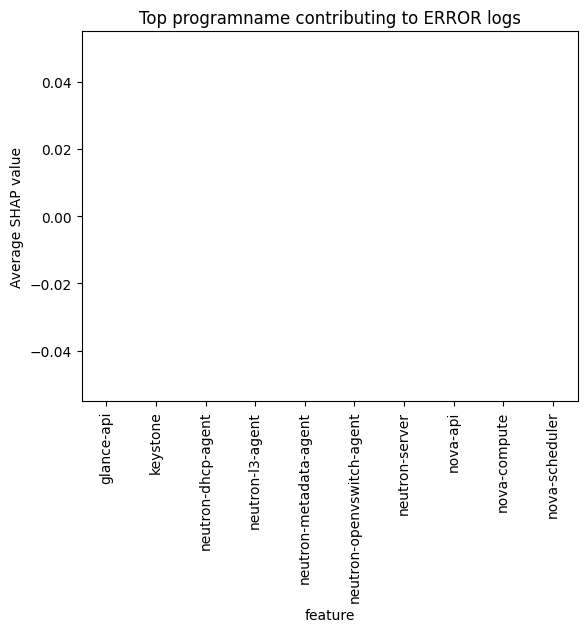


Top log_level by SHAP value:
feature
ERROR      482.756231
INFO        -0.101131
WARNING     -0.101131
Name: shap, dtype: float64


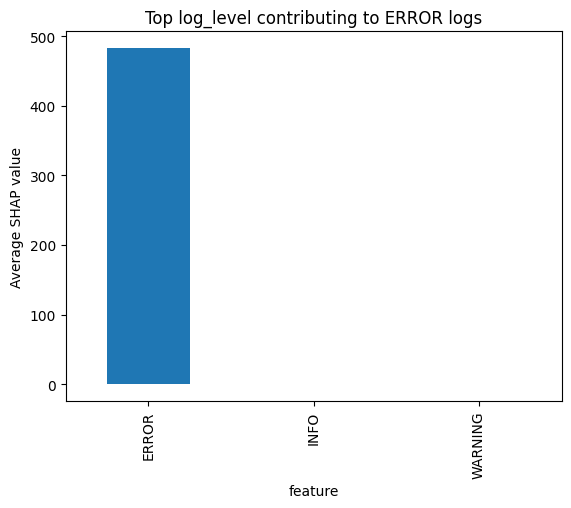


Top python_module by SHAP value:
feature
eventlet.wsgi.server                      0.0
glance_store._drivers.rbd                 0.0
keystone.server.flask.application         0.0
keystonemiddleware.auth_token             0.0
neutron.agent.agent_extensions_manager    0.0
neutron.agent.common.async_process        0.0
neutron.agent.dhcp.agent                  0.0
neutron.agent.l3.agent                    0.0
neutron.agent.linux.interface             0.0
neutron.agent.securitygroups_rpc          0.0
Name: shap, dtype: float64


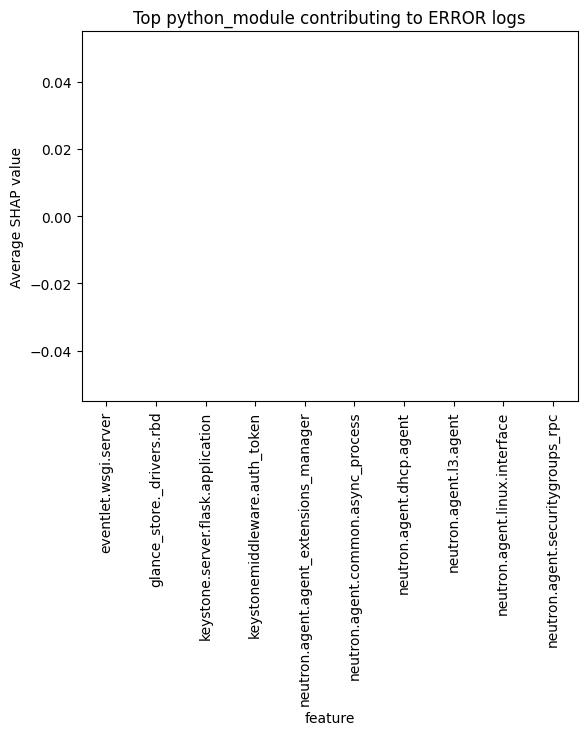

In [ ]:
import matplotlib.pyplot as plt

# Map encoded categories back to labels
for col in categorical_features:
    X_test[col+'_label'] = label_encoders[col].inverse_transform(X_test[col+'_enc'])

# Aggregate SHAP for each categorical feature
for col in categorical_features:
    df_tmp = pd.DataFrame({
        'feature': X_test[col+'_label'],
        'shap': shap_values[:, features.index(col+'_enc')]
    })
    importance = df_tmp.groupby('feature')['shap'].mean().sort_values(ascending=False)

    print(f"\nTop {col} by SHAP value:")
    print(importance.head(10))

    # Plot top 10
    importance.head(10).plot(kind='bar', title=f"Top {col} contributing to ERROR logs")
    plt.ylabel("Average SHAP value")
    plt.show()


Class imbalance is extreme → the model may be learning shortcuts (e.g., maybe log_level = ERROR always means is_error=1, so it ignores everything else).
No variance in feature for the error cases → if every ERROR row has the same python_module, SHAP for that feature will collapse to zero.
Overfitting to trivial patterns (your train/test accuracy of 1.0 is a red flag).


You’re describing a multi-view / hierarchical AI setup. That means:
Each dataset (logs, metrics, traces) gets its own model trained on its native format.
Then you combine their outputs/embeddings, instead of merging raw rows.



Per-dataset models
Logs → treat them like sequences of events:
Transformer / LSTM on programname, log_level, module, payload length
Output: embedding of log context + probability of ERROR
Metrics → numeric time-series:
Autoencoder / 1D CNN / Gradient Boosted Trees
Output: anomaly score or latent embedding
Traces → structured spans/operations:
Graph Neural Network (if you model spans as DAGs) or sequence Transformer
Output: embedding of trace flow



Since logs, metrics, and traces are very different data types, you’ll want a different model family for each. The goal is: train per dataset → extract patterns → later fuse if needed.




1. Logs dataset (categorical + text-like, sequential)
Data: programname, log_level, python_module, Pid, Payload, timestamp.
Goal: predict ERROR or anomaly.

start with XGBoost for tabular + sequence Transformer for temporal patterns.



2. Metrics dataset (time-series, numeric)
Neural time-series models
LSTM Autoencoder (reconstruction error → anomaly score).
1D CNN / Temporal Convolutional Network (fast, scalable).

LSTM autoencoder for anomaly detection + maybe Random Forest for supervised ERROR classification.



3. Traces dataset (structured spans, service calls)
✅ Recommendation: Transformer on ordered spans or GraphSAGE/GAT if you want service dependency insights.




## Summary of per-dataset modeling choices
Logs → XGBoost (tabular), Transformer (sequences)
Metrics → LSTM Autoencoder (time-series anomalies)
Traces → Transformer (sequence of spans) or GNN (graph traces)



In [ ]:
import pandas as pd

# Load datasets
logs_filtered = pd.read_csv("/content/logs.csv")
metrics_filtered = pd.read_csv("/content/metrics.csv")
traces_filtered = pd.read_csv("/content/traces.csv")



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load logs (already filtered in your setup)
logs = logs_filtered.copy()

# Target variable
logs["is_error"] = (logs["log_level"] == "ERROR").astype(int)

# Simple feature engineering
logs["Payload_len"] = logs["Payload"].astype(str).str.len()

features = ["programname", "python_module", "Pid", "Payload_len"]

X = logs[features].copy()
y = logs["is_error"]

# Encode categorical features
label_encoders = {}
for col in ["programname", "python_module"]:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Compute imbalance ratio
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=imbalance_ratio,  # handle imbalance
    random_state=42,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1
)

model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:36:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0      1.000     1.000     1.000     21104
           1      1.000     1.000     1.000         3

    accuracy                          1.000     21107
   macro avg      1.000     1.000     1.000     21107
weighted avg      1.000     1.000     1.000     21107

[[21104     0]
 [    0     3]]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Target variable
logs["is_error"] = (logs["log_level"] == "ERROR").astype(int)

# Feature engineering
logs["Payload_len"] = logs["Payload"].astype(str).str.len()

features = ["programname", "python_module", "Pid", "Payload_len"]

X = logs[features].copy()
y = logs["is_error"]

# Encode categorical features
label_encoders = {}
for col in ["programname", "python_module"]:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Fill NaN for categorical features with 'missing' (then re-encode)
for col in ["programname", "python_module"]:
    X_train[col] = X_train[col].fillna("missing")
    X_test[col] = X_test[col].fillna("missing")

# Fill numeric with median
for col in ["Pid", "Payload_len"]:
    X_train[col] = X_train[col].fillna(X_train[col].median())
    X_test[col] = X_test[col].fillna(X_train[col].median())


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


In [ ]:
imbalance_ratio = y_train.value_counts()[0] / max(1, y_train.value_counts()[1])

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=imbalance_ratio,
    random_state=42,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05
)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assume df is your log dataframe with ['programname','log_level','python_module','Pid','Payload','is_error']

# Feature engineering
df["Payload_len"] = df["Payload"].astype(str).str.len()

# Drop raw Payload (too high-dimensional as text for now)
X = df[["programname","log_level","python_module","Pid","Payload_len"]]
y = df["is_error"]

# Encode categoricals
label_encoders = {}
for col in ["programname", "log_level", "python_module"]:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


NameError: name 'df' is not defined